In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from tensorflow.keras import Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout

2022-10-31 16:04:03.298126: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-31 16:04:03.298152: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Load dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
print(f"x_train shape: {x_train.shape}")

x_train shape: (60000, 28, 28)


### Check for Missing Data

In [5]:
train_nan = np.isnan(x_train).sum()
print(f"train data Nans: {train_nan[train_nan != 0]}")

test_nan = np.isnan(x_test).sum()
print(f"test data Nans: {test_nan[test_nan != 0]}")

train data Nans: []
test data Nans: []


### Data Visualisation

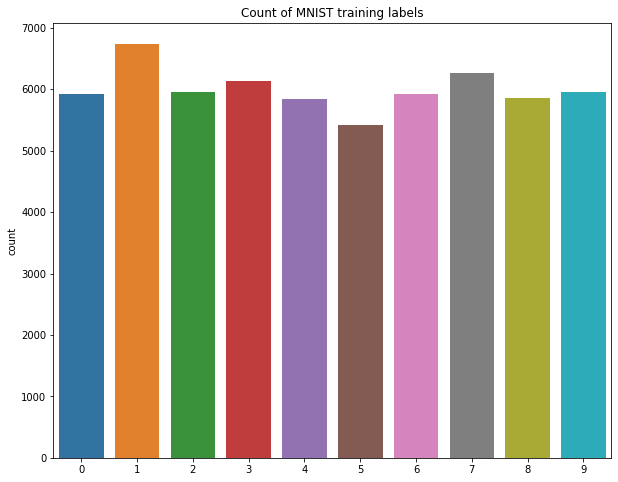

In [6]:
# Distribution of the digits in the dataset

fig, ax = plt.subplots(figsize=(10,8))
sns.countplot(x=y_train, ax=ax)
ax.set_title(f"Count of MNIST training labels")
plt.show()

###  Data Pre-processing

- The input data images are 2D grayscale pixel data (they have no color information and are 2D arrays) so we need to add an extra channel dimension to comply with the input format to the CNN. This needs to be in the form [row, columns, channels] where channels represents the color channels of the input data. 
- We scaling the pixel values when training a CNN to help the algorithms quickly reach the minima of the cost function (makes the flow of gradient descent smooth) 

In [7]:
# Reshape data to have a single channel
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

# determine the shape of the input images
input_shape = x_train.shape[1:]

# determine the number of classes
n_classes = len(np.unique(y_train))
print(f"input_shape: {input_shape}")
print(f"n_classes: {n_classes}")

# normalize pixel values
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

input_shape: (28, 28, 1)
n_classes: 10


## Display Handwritten digitis

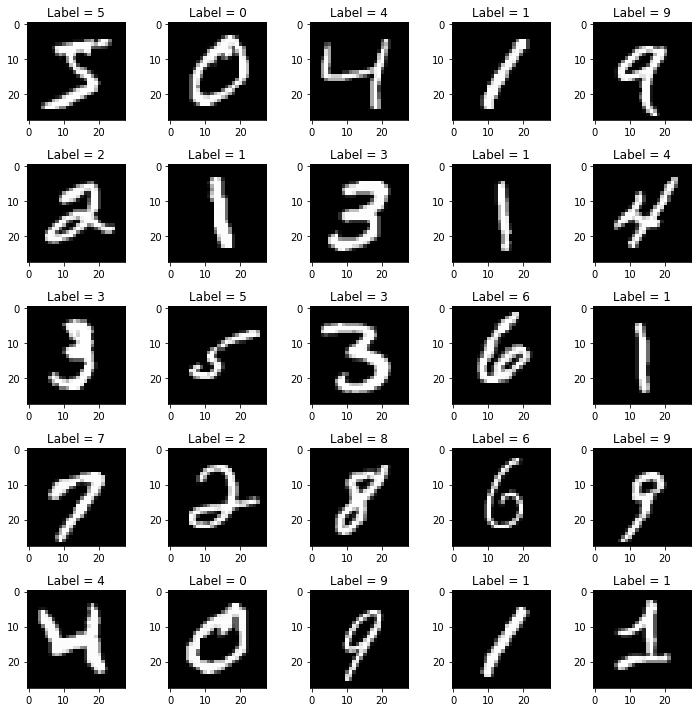

In [8]:
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
axs = axs.flatten()

# plot first few images
for i in range(25):
    ax = axs[i]
    # define subplot
    
    # plot raw pixel data
    ax.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    ax.set_title(f"Label = {y_train[i]}")

# show the figure
plt.tight_layout()
plt.show()

## Define the model

What does `kernel_initializer='he_uniform'` do?
Initilized the kernel weights by drawing samples from a uniform distribution within [-limit, limit], where limit = sqrt(6 / fan_in) (fan_in is the number of input units in the weight tensor).

What is a `MaxPool2D` layer?
Max pooling operation for 2D spatial data (Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size ) for each channel of the input)

What is a `Flatten` layer?
Flatten layer is used to make the multidimensional input one-dimensional, commonly used in the transition from the convolution layer to the full connected layer.


What is a `Dense` layer?
A densely-connected NN layer in which every output depends on every input

What is a `Dropout` layer?
The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting

Why do we use `sparse_categorical_crossentropy` loss function and `accuracy` for accuracy?
We use "sparse" since we are not one hot encoding the labels.

In [9]:

model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

# Define loss and optimizer
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

2022-10-31 16:04:07.290490: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-31 16:04:07.290527: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Ryan-Asus): /proc/driver/nvidia/version does not exist
2022-10-31 16:04:07.291192: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
history = {}

In [11]:
# fit the model
history['mnist_1'] = model.fit(
    x_train, 
    y_train, 
    validation_split = 0.2,
    epochs=20, 
    batch_size=128, 
    verbose=0,
    use_multiprocessing=True
)

# history["mnist_1"]

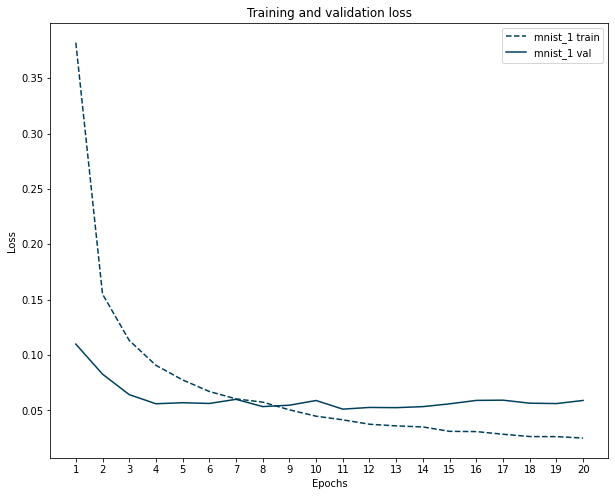

In [12]:
# Plot Train and Validation loss

fig, ax = plt.subplots(1,1, figsize=(10,8))
colours = ["#003f5c","#bc5090", "#228b22"] 

for model_name, color in zip(["mnist_1"], colours):

    history_dict = history[model_name].history
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(loss) + 1)
    plt.xticks(np.arange(1,21, 1))
    plt.plot(epochs, loss, label=f"{model_name} train", linestyle="--", color=color)
    plt.plot(epochs, val_loss, label=f"{model_name} val", color=color)
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    
plt.legend()
plt.show()

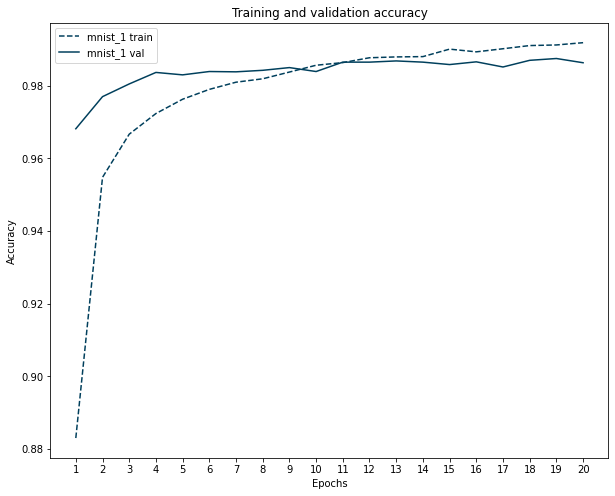

In [13]:
# Plot Train and Validation Accuracy

fig, ax = plt.subplots(1,1, figsize=(10,8))
colours = ["#003f5c","#bc5090", "#228b22"] 

for model_name, color in zip(["mnist_1"], colours):

    history_dict = history[model_name].history
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']

    epochs = range(1, len(loss) + 1)
    plt.xticks(np.arange(1,21, 1))
    plt.plot(epochs, acc, label=f"{model_name} train", linestyle="--", color=color)
    plt.plot(epochs, val_acc, label=f"{model_name} val", color=color)
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    

plt.legend()
plt.show()

In [14]:
# Evaluate the model

loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Accuracy: {accuracy:.3f}")
print(f"Loss: {loss:.3f}")

Accuracy: 0.986
Loss: 0.050


1/1 [==============================] - 0s 72ms/step
actual_label 7
predicted_label 7
1/1 [==============================] - 0s 16ms/step
actual_label 2
predicted_label 2
1/1 [==============================] - 0s 13ms/step
actual_label 1
predicted_label 1
1/1 [==============================] - 0s 14ms/step
actual_label 0
predicted_label 0
1/1 [==============================] - 0s 13ms/step
actual_label 4
predicted_label 4
1/1 [==============================] - 0s 14ms/step
actual_label 1
predicted_label 1
1/1 [==============================] - 0s 13ms/step
actual_label 4
predicted_label 4
1/1 [==============================] - 0s 12ms/step
actual_label 9
predicted_label 9
1/1 [==============================] - 0s 13ms/step
actual_label 5
predicted_label 5
1/1 [==============================] - 0s 13ms/step
actual_label 9
predicted_label 9
1/1 [==============================] - 0s 13ms/step
actual_label 0
predicted_label 0
1/1 [==============================] - 0s 14ms/step
actual_label 

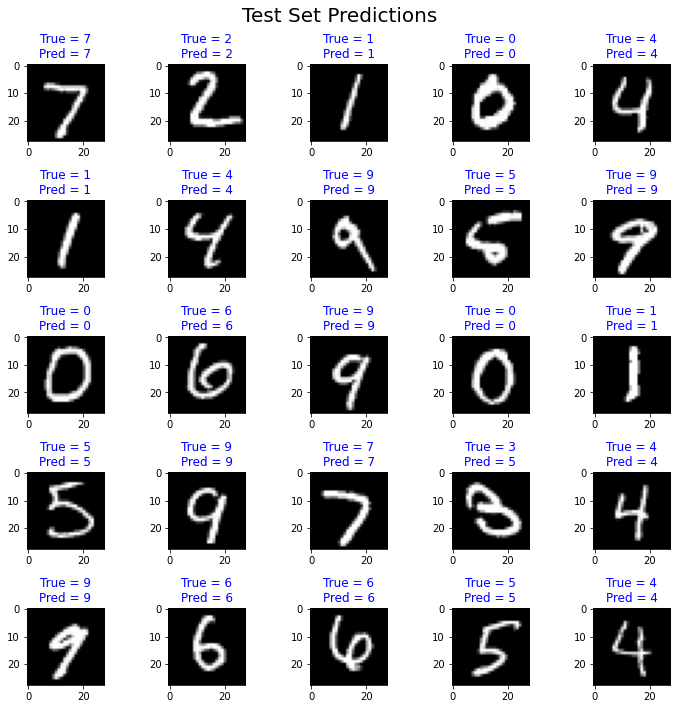

In [15]:
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
axs = axs.flatten()

# plot first few images
for i in range(25):
    ax = axs[i]
    # define subplot
    
    # plot raw pixel data
    image = x_test[i]
    ax.imshow(image, cmap=plt.get_cmap('gray'))
    predicted_label_arr = model.predict(np.asarray([image]))
    predicted_label = np.argmax(predicted_label_arr, -1)[0]
    
    actual_label = y_test[i]
    print("actual_label", actual_label)
    print("predicted_label", predicted_label)

    title = f"True = {actual_label}\nPred = {predicted_label}"
    if actual_label == predicted_label:
        colour = "blue"
    else:
        color = "red"
    
    ax.set_title(title, color=colour)

# show the figure
plt.suptitle("Test Set Predictions", fontsize=20)
plt.tight_layout()
plt.show()

## TODO:
- Add more preprocessing steps to clean up images
- Add a interactive window where a user can draw a number and then the model can predict the label